### Calculating the sensitivity of SSAM output to small fluctuations in input
Quantifying differences in the output files of Salish Sea Atlantis Model simulations with small differences in input

In [22]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

In [23]:
def my_rmsd_percent(one, two):
    one_all_depths = one.sum(axis=2)
    two_all_depths = two.sum(axis=2)
    one_all_boxes = one_all_depths.sum(axis=1)
    two_all_boxes = two_all_depths.sum(axis=1)
    diff = abs(one_all_boxes-two_all_boxes)
    diff_ratio = diff/two_all_boxes
    diff_ratio_squared = diff_ratio**2
    diff_ratio_squared_mean = diff_ratio_squared.mean(axis=0, skipna=True)
    my_rmsd_percent = ((diff_ratio_squared_mean)**(1/2))*100
    return my_rmsd_percent

In [24]:
def my_rmsd_percent_resampled(one, two):
    one_all_depths = one.sum(dim='z')
    two_all_depths = two.sum(dim='z')
    one_all_boxes = one_all_depths.sum(dim='b')
    two_all_boxes = two_all_depths.sum(dim='b')
    diff = abs(one_all_boxes-two_all_boxes)
    diff_ratio = diff/two_all_boxes
    diff_ratio_squared = diff_ratio**2
    diff_ratio_squared_mean = diff_ratio_squared.mean(dim='t', skipna=True)
    my_rmsd_percent_resampled = ((diff_ratio_squared_mean)**(1/2))*100
    return my_rmsd_percent_resampled

Using new sensitivity control file based on recalibrated bio SS_run_calibration.prm with flagscaleinit=0

In [25]:
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/v6719_50y_VBITBUCKET-ddmove0-2-ZGppreyWS-1-PL/outputSalishSea.nc"
control= xr.open_dataset(str(control_file), decode_cf=True)
control_five_year_mean = control.resample(t='5Y').mean()

In [26]:
scenario_path = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Sensitivity/')

In [27]:
# Masking land boxes
Temps = np.ma.filled(control.Temp[1,:,5], np.nonzero)
(ocean_boxes) = Temps.nonzero()
ocean_boxes = ocean_boxes[0]
ocean_boxes = ocean_boxes[1:ocean_boxes.size-1]
#ocean_boxes

Fluctuations used: 10% initialy increase in biomass or MS or PS

In [28]:
#file_dict = {'BC', 'FHE', 'MA', 'ORR', 'PL', 'PS', 'WHB'}
file_dict = {'MA', 'PS'}
scens = sorted([p for p in scenario_path.glob('v6719_*x11/outputSalishSea.nc')])

Process files with snapshot data

In [29]:
# measured opening of scenario files
for path in scens:
    nm = str(path).split(sep = '/')
    name = nm[7]
    #name1 = nm[7].split(sep='_')
    #name = name1[1]

    rmsd_data = pd.DataFrame({'scenario_file': [],
                    'species': [],
                    'RMSD%': []},)
    scenario = xr.open_dataset(str(path), decode_cf=True)
    for species in groups.all_pelagic:
        one = control.variables[groups.all_pelagic[species] + '_N'][:][ocean_boxes]
        two = scenario.variables[groups.all_pelagic[species] +'_N'][:][ocean_boxes]

        rmsd_score = my_rmsd_percent(one, two)
        rmsd_data.loc[len(rmsd_data.index)] = [name, species, float(rmsd_score)]                       
    rmsd_data.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Sensitivity/rmsd_percent_snapshot"+name+"_16Jul2025.csv")

Process files with 5-year resampled data

In [30]:
#file_dict = {'BC', 'FHE', 'MA', 'ORR', 'PL', 'PS', 'WHB'}
#file_dict = {'MA', 'PS'}

#scens = sorted([p for p in scenario_path.glob('butterflyeffect_*x11/outputSalishSea.nc')])

# measured opening of scenario files
for path in scens:
    nm = str(path).split(sep = '/')
    name = nm[7]
    #name1 = nm[7].split(sep='_')
    #name = name1[1]

    rmsd_data = pd.DataFrame({'scenario_file': [],
                    'species': [],
                    'RMSD%': []},)
    scenario = xr.open_dataset(str(path), decode_cf=True)
    scenario_five_year_mean = scenario.resample(t='5Y').mean()
    for species in groups.all_pelagic:
        two = scenario_five_year_mean.variables[groups.all_pelagic[species] +'_N'][:, ocean_boxes, :]
        one = control_five_year_mean.variables[groups.all_pelagic[species] + '_N'][:, ocean_boxes, :]

        rmsd_score = my_rmsd_percent_resampled(one, two)
        rmsd_data.loc[len(rmsd_data.index)] = [name, species, float(rmsd_score)]                       
    rmsd_data.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Sensitivity/rmsd_percent_resampled_"+name+"_16Jul2025.csv")

Aggregating planktonic biomass

In [31]:
def my_rmsd_percent_sum(one, two):
    one = one.sum(dim='z')
    two = two.sum(dim='z')
    one = one.sum(dim='b')
    two = two.sum(dim='b')
    one = one.sum(dim='t')
    two = two.sum(dim='t')
    diff_ratio = (abs(one-two)/two)
    diff_ratio_squared = diff_ratio**2
    my_rmsd_percent_sum = ((diff_ratio_squared)**(1/2))*100
    return my_rmsd_percent_sum

In [32]:
for path in scens:
    nm = str(path).split(sep = '/')
    name = nm[7]
    #name1 = nm[7].split(sep='_')
    #name = name1[1]

    rmsd_data = pd.DataFrame({'scenario_file': [],
                    'species': [],
                    'RMSD%': []},)
    scenario = xr.open_dataset(str(path), decode_cf=True)
    scenario_five_year_mean = scenario.resample(t='5Y').mean()
    for species in groups.plankton:
        two = scenario_five_year_mean.variables[groups.plankton[species] +'_N'][:, ocean_boxes, :]
        one = control_five_year_mean.variables[groups.plankton[species] + '_N'][:, ocean_boxes, :]

        rmsd_score = my_rmsd_percent_sum(one, two)
        rmsd_data.loc[len(rmsd_data.index)] = [name, species, float(rmsd_score)]                       
    rmsd_data.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Sensitivity/rmsd_percent_sum_"+name+"_16Jul2025.csv")

In [33]:
def my_rmsd_percent_sum2(one, two):
    one = one.sum(axis=2)
    two = two.sum(axis=2)
    one = one.sum(axis=1)
    two = two.sum(axis=1)
    one = one.sum(axis=0)
    two = two.sum(axis=0)
    diff_ratio = (abs(one-two)/two)
    diff_ratio_squared = diff_ratio**2
    my_rmsd_percent_sum2 = ((diff_ratio_squared)**(1/2))*100
    return my_rmsd_percent_sum2

In [34]:
for path in scens:
    nm = str(path).split(sep = '/')
    name = nm[7]
    #name1 = nm[7].split(sep='_')
    #name = name1[1]

    rmsd_data = pd.DataFrame({'scenario_file': [],
                    'species': [],
                    'RMSD%': []},)
    scenario = xr.open_dataset(str(path), decode_cf=True)
    for species in groups.all_pelagic:
        one = control.variables[groups.all_pelagic[species] + '_N'][:][ocean_boxes]
        two = scenario.variables[groups.all_pelagic[species] +'_N'][:][ocean_boxes]

        rmsd_score = my_rmsd_percent_sum2(one, two)
        rmsd_data.loc[len(rmsd_data.index)] = [name, species, float(rmsd_score)]                       
    rmsd_data.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Sensitivity/rmsd_percent_sum2_"+name+"_16Jul2025.csv")

In [35]:
def benthic_rmsd_percent_resampled(one, two):
    one_sea = one.sum(dim='b')
    two_sea = two.sum(dim='b')
    diff = abs(one_sea-two_sea)
    diff_ratio = diff/two_sea
    diff_ratio_squared = diff_ratio**2
    diff_ratio_squared_mean = diff_ratio_squared.mean(dim='t', skipna=True)
    benthic_rmsd_percent_resampled = ((diff_ratio_squared_mean)**(1/2))*100
    return benthic_rmsd_percent_resampled

In [36]:
for path in scens:
    nm = str(path).split(sep = '/')
    name = nm[7]
    #name1 = nm[7].split(sep='_')
    #name = name1[1]

    rmsd_data = pd.DataFrame({'scenario_file': [],
                    'species': [],
                    'RMSD%': []},)
    scenario = xr.open_dataset(str(path), decode_cf=True)
    scenario_five_year_mean = scenario.resample(t='5Y').mean()
    for species in groups.benthos:
        two = scenario_five_year_mean.variables[groups.benthos[species] +'_N'][:, ocean_boxes]
        one = control_five_year_mean.variables[groups.benthos[species] + '_N'][:, ocean_boxes]

        rmsd_score = benthic_rmsd_percent_resampled(one, two)
        rmsd_data.loc[len(rmsd_data.index)] = [name, species, float(rmsd_score)]                       
    rmsd_data.to_csv("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Sensitivity/rmsd_benthos_resampled_"+name+"_16Jul2025.csv")

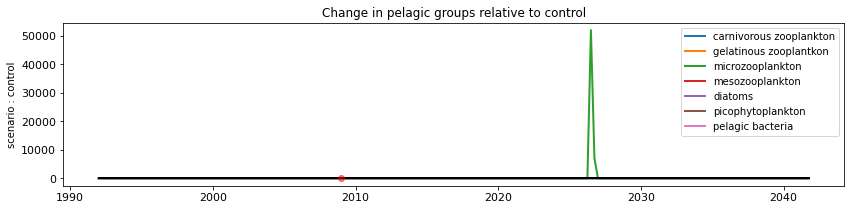

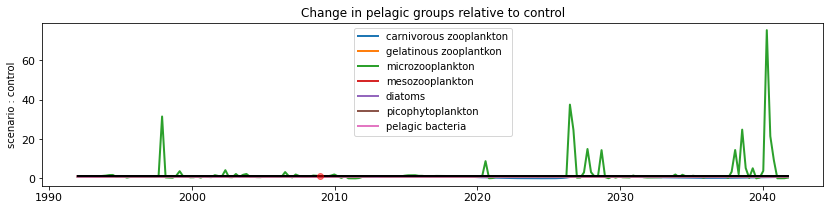

In [37]:
time = np.ma.filled(control.variables['t'], np.nan)
start = 0
end = time.size-1
event_start = np.datetime64('2009-01-01')
for path in scens:
    scenario = xr.open_dataset(str(path), decode_cf=True)
    splot.compare_groups_pelagic(groups.plankton,scenario, control, time, start, end, groups.salish_sea, event_start, y_min=None, y_max=None)

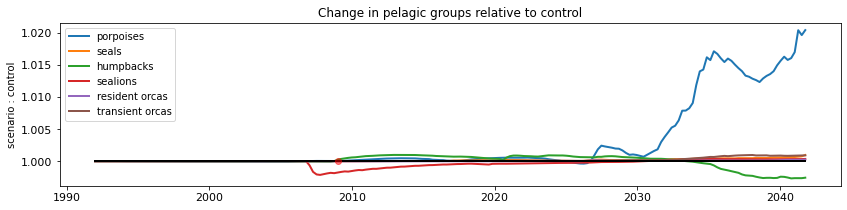

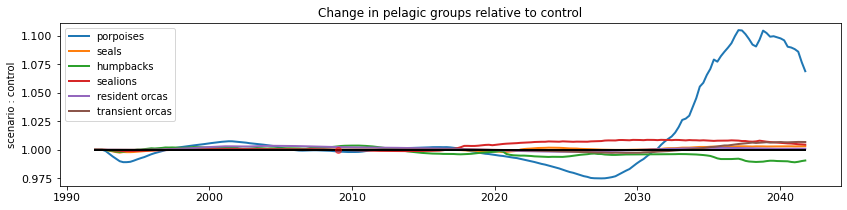

In [38]:
for path in scens:
    scenario = xr.open_dataset(str(path), decode_cf=True)
    splot.compare_groups_pelagic(groups.mammals,scenario, control, time, start, end, groups.salish_sea, event_start, y_min=None, y_max=None)

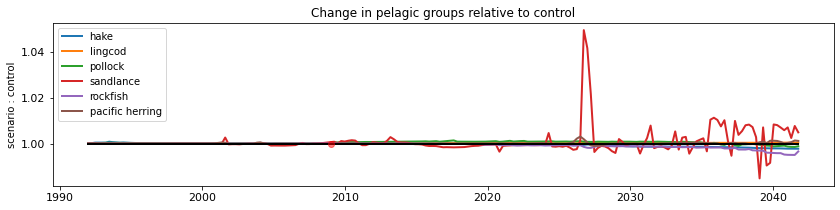

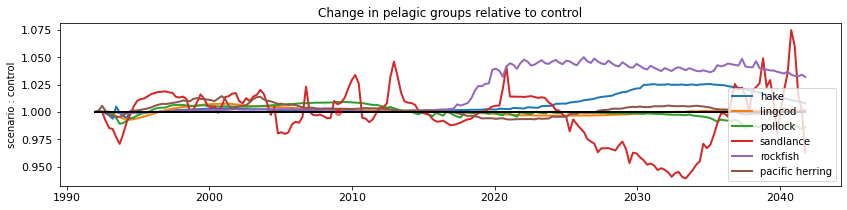

In [39]:
for path in scens:
    scenario = xr.open_dataset(str(path), decode_cf=True)
    splot.compare_groups_pelagic(groups.named_fish,scenario, control, time, start, end, groups.salish_sea, event_start, y_min=None, y_max=None)

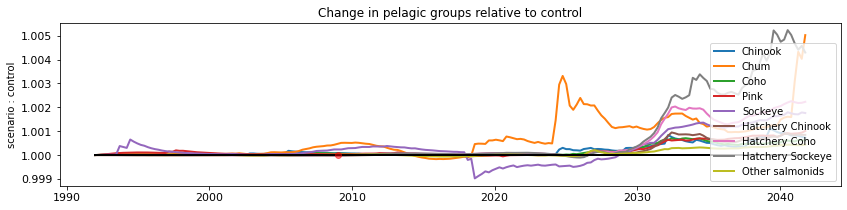

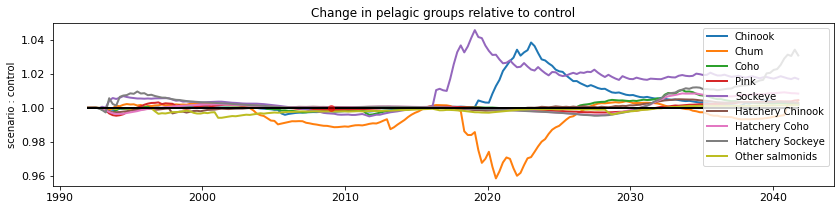

In [40]:
for path in scens:
    scenario = xr.open_dataset(str(path), decode_cf=True)
    splot.compare_groups_pelagic(groups.salmon,scenario, control, time, start, end, groups.salish_sea, event_start, y_min=None, y_max=None)

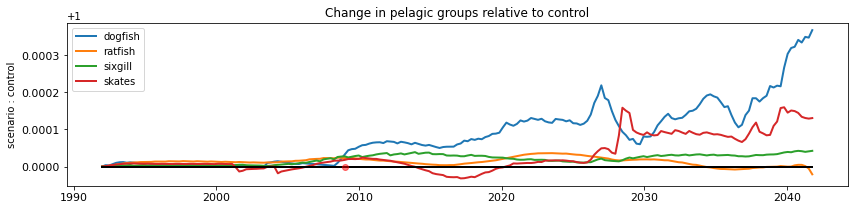

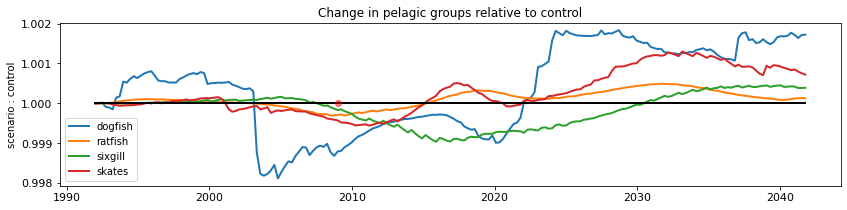

In [41]:
for path in scens:
    scenario = xr.open_dataset(str(path), decode_cf=True)
    splot.compare_groups_pelagic(groups.sharks,scenario, control, time, start, end, groups.salish_sea, event_start, y_min=None, y_max=None)

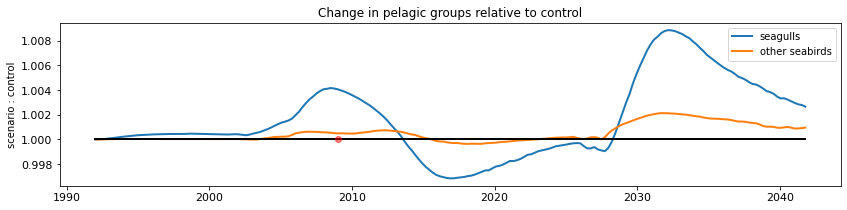

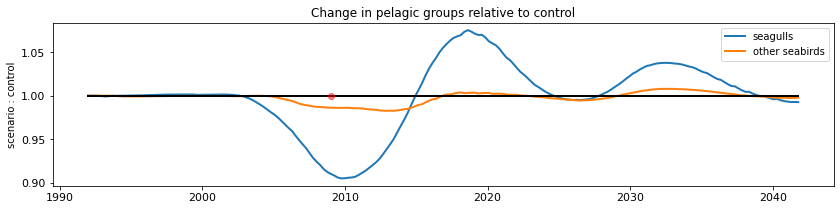

In [42]:
for path in scens:
    scenario = xr.open_dataset(str(path), decode_cf=True)
    splot.compare_groups_pelagic(groups.birds,scenario, control, time, start, end, groups.salish_sea, event_start, y_min=None, y_max=None)